# 🧬 Demo: Genetic Algorithm Individual Class

This notebook demonstrates the functionality of the `Individual` abstract base class and a concrete subclass `BinaryIndividual`. The goal is to show how this flexible design supports mutation, crossover, fitness evaluation, and operator overloading for use in genetic algorithms.

## 🧱 Class Overview

- `Individual`: An abstract class that defines a genetic algorithm individual.
  - Includes pluggable methods: `random_representation`, `mutation`, `crossover`, `calculate_fitness`, and `semantic_key`.
  - Overloads key operators for convenience:
    - `@` → Crossover (e.g., `child1, child2 = parent1 @ parent2`)
    - `**` → Multiple self-crossovers (e.g., `clones = parent ** 3`)
    - `()` → Evaluate fitness (e.g., `fitness = individual()`)
    - Comparison (`<`, `>`, etc.) based on fitness
    - Hashing and equality via `semantic_key` for use in sets and dictionaries

- `BinaryIndividual`: A concrete implementation where the genome is a list of 0s and 1s.
  - Fitness is defined as the number of 1s (maximize ones).
  - Mutation flips a single bit.
  - Crossover combines parts of the genome from two parents.

## ✅ Features Demonstrated

1. **Random Initialization**
   - Create individuals with random binary genomes.

2. **Fitness Evaluation**
   - Automatically lazily computed and cached.

3. **Mutation**
   - Use `mutation()` to modify an individual in-place.

4. **Crossover**
   - Use the `@` operator (or `crossover()`) to generate a child from two parents.

5. **Iteration**
   - Use a `for` loop to generate several mutated versions from an individual.

6. **Operator Overloading**
   - Use Python syntax sugar for fitness, crossover, and comparisons.

7. **Sorting Individuals**
   - Individuals are comparable by fitness, so they can be sorted.

8. **Using Sets**
   - `Individual` instances are hashable via `semantic_key`, allowing deduplication in sets or as dictionary keys.

This modular and extensible framework allows for easy implementation of different genome types and evolutionary strategies.

In [1]:
from abc import ABC, abstractmethod
from copy import deepcopy
import random

In [2]:
# import a script in another directory
import sys
import os
from typing import List, Callable
import pandas as pd
relative_path = os.path.join("..", "Classes")
print(sys.path)
sys.path.append(relative_path)
#sorted(os.listdir(relative_pathhgggggfffddwwddssddbbbbbbeeeeeeeaaaaaaaaaatttttttrrrrrrriiiiiizzzzzzzzzzzzz))
from Individual import Individual
from Solution import Solution

['/opt/anaconda3/envs/Cifo_RunningDinner/lib/python312.zip', '/opt/anaconda3/envs/Cifo_RunningDinner/lib/python3.12', '/opt/anaconda3/envs/Cifo_RunningDinner/lib/python3.12/lib-dynload', '', '/opt/anaconda3/envs/Cifo_RunningDinner/lib/python3.12/site-packages']


In [3]:
class BinaryIndividual(Individual):
    def __init__(self, genome_length=10):
        super().__init__()
        self.genome_length = genome_length
        self.genome = [0] * genome_length
        self.random_representation()

    def random_representation(self):
        self.genome = [random.choice([0, 1]) for _ in range(self.genome_length)]

    def check_representation(self):
        return all(g in [0, 1] for g in self.genome)

    def calculate_fitness(self):
        return sum(self.genome)  # Maximize number of 1s

    def mutation(self):
        idx = random.randint(0, self.genome_length - 1)
        self.genome[idx] = 1 - self.genome[idx]  # Flip bit
        return self

    def crossover(self, other):
        # Single-point crossover producing two children
        pivot = random.randint(1, self.genome_length - 1)
        # Child 1: head from self, tail from other
        child1 = self.copy_Individual()
        child1.genome = self.genome[:pivot] + other.genome[pivot:]
        # Child 2: head from other, tail from self
        child2 = self.copy_Individual()
        child2.genome = other.genome[:pivot] + self.genome[pivot:]
        return child1, child2

    def semantic_key(self):
        return tuple(self.genome)

In [4]:
import random
from typing import List

import random
from typing import List

def tournament_selection(
    population: List[Individual],
    maximization: bool = False,
    k: int = 3
) -> Individual:
    """
    k-way tournament (with replacement), unified for minimization or maximization.

    Parameters
    ----------
    population : List[Individual]
        Current population.
    maximization : bool, default=False
        If False, lower fitness is better (minimize). If True, higher fitness is better.
    k : int, default=3
        Tournament size (number of contestants).

    Returns
    -------
    Individual
        The tournament winner.
    """
    # pick k random contestants (with replacement)
    contestants = random.choices(population, k=k)
    # choose best according to the mode
    if maximization:
        # higher fitness wins
        return max(contestants, key=lambda ind: ind.fitness)
    else:
        # lower fitness wins
        return min(contestants, key=lambda ind: ind.fitness)


def rank_selection(
    population: List[Individual],
    maximization: bool = False
) -> Individual:
    """
    Rank-based roulette selection.

    1. Sort population by fitness.
    2. Assign weights N, N-1, …, 1 (best gets highest weight).
    3. Sample one individual proportionally to its weight.

    Parameters
    ----------
    population : List[Individual]
        Current population.
    maximization : bool, default False
        If False, lower fitness is better; if True, higher fitness is better.

    Returns
    -------
    Individual
        The selected individual.
    """
    # best-first sort: reverse=True if maximize, else reverse=False
    ranked = sorted(
        population,
        key=lambda ind: ind.fitness,
        reverse=maximization
    )
    n = len(ranked)
    weights = list(range(n, 0, -1))  # best gets weight n, worst gets 1
    return random.choices(ranked, weights=weights, k=1)[0]

# Testing Features

## Create two individuals


In [5]:
ind1 = BinaryIndividual()
ind2 = BinaryIndividual()

print("Individual 1:", ind1.genome)
print("Fitness 1:", float(ind1))

print("Individual 2:", ind2.genome)
print("Fitness 2:", float(ind2))

Individual 1: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Fitness 1: 5.0
Individual 2: [1, 0, 1, 0, 1, 1, 0, 1, 1, 1]
Fitness 2: 7.0


## Crossover


In [6]:
child1, child2 = ind1 @ ind2
print("\nChildren (crossover):", child1.genome,",", child2.genome)
print("Fitness (children):", float(child1),",", float(child2))


Children (crossover): [0, 0, 0, 1, 1, 1, 0, 1, 1, 1] , [1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Fitness (children): 6.0 , 6.0


## Mutation


In [7]:
mutant = ind1.copy_Individual()
mutant.mutation()
print("\nMutated Individual:", mutant.genome)
print("Fitness (mutated):", float(mutant))


Mutated Individual: [0, 0, 0, 1, 1, 0, 1, 1, 1, 1]
Fitness (mutated): 6.0


## Iteration (generate mutated versions)

In [8]:
print("\nMultiple Mutations:")
for i, m in enumerate(ind1):
    print(f"Mutation {i+1}:", m.genome, "Fitness:", float(m))


Multiple Mutations:
Mutation 1: [0, 0, 0, 1, 0, 0, 1, 1, 1, 0] Fitness: 4.0
Mutation 2: [0, 0, 0, 0, 1, 0, 1, 1, 1, 0] Fitness: 4.0
Mutation 3: [0, 0, 0, 0, 1, 0, 1, 1, 1, 0] Fitness: 4.0
Mutation 4: [0, 0, 0, 1, 0, 0, 1, 1, 1, 0] Fitness: 4.0
Mutation 5: [0, 0, 0, 1, 1, 0, 0, 1, 1, 0] Fitness: 4.0


## Operator Overloading

In [9]:
print("\nUsing ** Operator for Self-Crossover")
clone_pairs = ind1 ** 3  # a list of (child1, child2) tuples

for i, (c1, c2) in enumerate(clone_pairs, start=1):
    print(f"Pair {i}, Child 1:", c1.genome)
    print(f"Pair {i}, Child 2:", c2.genome)


Using ** Operator for Self-Crossover
Pair 1, Child 1: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Pair 1, Child 2: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Pair 2, Child 1: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Pair 2, Child 2: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Pair 3, Child 1: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Pair 3, Child 2: [0, 0, 0, 1, 1, 0, 1, 1, 1, 0]


## Comparison


In [10]:
print("\nIs Individual 1 better than Individual 2?", ind1 > ind2)


Is Individual 1 better than Individual 2? False


## Sorting and Deduplication via Set

In [11]:
print("\n=== Sorting Individuals by Fitness ===")
individuals = [BinaryIndividual() for _ in range(5)]

for i, ind in enumerate(individuals):
    print(f"Ind {i+1}: Genome = {ind.genome}, Fitness = {float(ind)}")

sorted_individuals = sorted(individuals)
print("\nSorted by fitness (ascending):")
for i, ind in enumerate(sorted_individuals):
    print(f"Rank {i+1}: Genome = {ind.genome}, Fitness = {float(ind)}")


=== Sorting Individuals by Fitness ===
Ind 1: Genome = [0, 0, 0, 1, 1, 0, 0, 1, 0, 1], Fitness = 4.0
Ind 2: Genome = [0, 0, 0, 1, 0, 1, 1, 1, 1, 1], Fitness = 6.0
Ind 3: Genome = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0], Fitness = 2.0
Ind 4: Genome = [1, 1, 0, 1, 1, 0, 1, 0, 1, 1], Fitness = 7.0
Ind 5: Genome = [1, 1, 1, 0, 1, 1, 1, 1, 0, 0], Fitness = 7.0

Sorted by fitness (ascending):
Rank 1: Genome = [1, 0, 0, 0, 0, 0, 0, 1, 0, 0], Fitness = 2.0
Rank 2: Genome = [0, 0, 0, 1, 1, 0, 0, 1, 0, 1], Fitness = 4.0
Rank 3: Genome = [0, 0, 0, 1, 0, 1, 1, 1, 1, 1], Fitness = 6.0
Rank 4: Genome = [1, 1, 0, 1, 1, 0, 1, 0, 1, 1], Fitness = 7.0
Rank 5: Genome = [1, 1, 1, 0, 1, 1, 1, 1, 0, 0], Fitness = 7.0


## Storing Unique Individuals in a Set

In [12]:
print("\n=== Deduplication with Set ===")
ind1 = BinaryIndividual()
ind2 = ind1.copy_Individual(delete_fitness=False)  # Exact copy

# Mutate a third individual to likely get a different genome
ind3 = BinaryIndividual()
ind3.mutation()

ind_set = {ind1, ind2, ind3}

for i, ind in enumerate(ind_set):
    print(f"Unique {i+1}: Genome = {ind.genome}, Fitness = {float(ind)}")

print(f"\nTotal unique individuals: {len(ind_set)}")


=== Deduplication with Set ===
Unique 1: Genome = [1, 1, 0, 0, 0, 1, 0, 1, 0, 0], Fitness = 4.0
Unique 2: Genome = [0, 1, 0, 1, 1, 1, 0, 0, 0, 1], Fitness = 5.0

Total unique individuals: 2


## Selection Mechanisms

In [13]:
# Parameter values for illustration
POP_SIZE = 50
population = [BinaryIndividual() for _ in range(POP_SIZE)]

# run the two selection mechanisms
winner_tournament = tournament_selection(population, k=5)   # play with k
winner_rank       = rank_selection(population)

print("Tournament winner fitness :", winner_tournament.fitness)
print("Rank-based winner fitness :", winner_rank.fitness)

Tournament winner fitness : 2
Rank-based winner fitness : 5


In [14]:
import numpy as np

def sample(selector, n=50):
    return np.mean([selector(population).fitness for _ in range(n)])

print("Avg fitness (tournament):", sample(lambda pop: tournament_selection(pop, k=3)))
print("Avg fitness (rank)      :", sample(rank_selection))


Avg fitness (tournament): 3.72
Avg fitness (rank)      : 4.32


## Genetic Algorithm

In [15]:
import os
import random
import pandas as pd
from copy import deepcopy
from typing import Callable, List
from Solution import Solution  # or whatever your base class is

def genetic_algorithm(
    initial_population: List[BinaryIndividual],
    gen_count: int,
    selection_algorithm: Callable[[List[BinaryIndividual], bool], BinaryIndividual],
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.2,
    elitism: bool = True,
    verbose: bool = False,
):
    """
    Evolves a population for `gen_count` generations and returns:
      • best_ind: the best individual seen *across all* generations
      • best_fitness_over_gens: list of best fitness per generation
    """
    # Initialize population
    population = initial_population
    best_fitness_over_gens: List[float] = []

    # determine best_of function
    if maximization:
        best_of = lambda pop: max(pop, key=lambda ind: ind.calculate_fitness())
    else:
        best_of = lambda pop: min(pop, key=lambda ind: ind.calculate_fitness())

    # Seed the global best from initial population
    global_best = deepcopy(best_of(population))

    for gen in range(1, gen_count + 1):
        if verbose:
            print(f"--- Generation {gen} ---")

        new_pop: List[BinaryIndividual] = []
        # elitism: carry over last generation's best
        if elitism:
            new_pop.append(deepcopy(best_of(population)))

        # create offspring
        while len(new_pop) < len(population):
            p1 = selection_algorithm(population, maximization)
            p2 = selection_algorithm(population, maximization)
            if random.random() < xo_prob:
                off1, off2 = p1.crossover(p2)
            else:
                off1, off2 = deepcopy(p1), deepcopy(p2)
            if random.random() < mut_prob:
                off1 = off1.mutation()
            if random.random() < mut_prob:
                off2 = off2.mutation()
            new_pop.append(off1)
            if len(new_pop) < len(population):
                new_pop.append(off2)

        population = new_pop

        # track best of this generation
        this_best = best_of(population)
        this_fit  = this_best.calculate_fitness()
        best_fitness_over_gens.append(this_fit)

        # update global best if improved
        if maximization:
            if this_fit > global_best.calculate_fitness():
                global_best = deepcopy(this_best)
        else:
            if this_fit < global_best.calculate_fitness():
                global_best = deepcopy(this_best)

        if verbose:
            print(f"Best this gen: {this_fit}, Global best: {global_best.calculate_fitness()}")

    # return the individual with the best fitness across all gens, plus the trace
    return global_best, best_fitness_over_gens

In [16]:
_,fitness = genetic_algorithm(
    initial_population=[BinaryIndividual() for _ in range(10)],
    gen_count=5,
    selection_algorithm=tournament_selection,
    maximization=False,
    xo_prob=0.9,
    mut_prob=0.2,
    elitism=True,
    verbose=False
)

In [17]:
def function_to_minimize(p_xo,p_mut):
    _,fitness = genetic_algorithm(
    initial_population=[BinaryIndividual() for _ in range(10)],
    gen_count=5,
    selection_algorithm=tournament_selection,
    maximization=False,
    xo_prob=p_xo,
    mut_prob=p_mut,
    elitism=True,
    verbose=False
)
    return fitness[-1]  # Return the last fitness value

In [18]:
from scipy.optimize import minimize

# Initial guess for the parameters\
initial_guess = [0.5, 0.5]  # xo_prob and mut_prob
bounds = [(0, 1), (0, 1)]  # Bounds for xo_prob and mut_prob
result = minimize(
    lambda x: function_to_minimize(x[0], x[1]),
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B'
)
print("Optimized parameters:", result.x)
print("Final fitness:", result.fun)

Optimized parameters: [0.5        0.50000269]
Final fitness: 1


## Genetic Alg Run to CSV

In [19]:
from pandas.errors import EmptyDataError


def genetic_algorithm_runs_to_csv(
    run_count: int,
    pop_factory: Callable[[], List[BinaryIndividual]],
    gen_count: int,
    selection_algorithm: Callable,
    csv_filename: str = "ga_results.csv",
    maximization: bool = False,
    xo_prob: float = 0.9,
    mut_prob: float = 0.2,
    elitism: bool = True,
    verbose: bool = False,
) -> pd.DataFrame:
    # Locate or create the Results folder & file path
    base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    results_dir = os.path.join(base_dir, "Results")
    os.makedirs(results_dir, exist_ok=True)
    full_path = os.path.join(results_dir, csv_filename)

    # Try to read an existing CSV with its index
    try:
        df = pd.read_csv(full_path, index_col=0)
        existing = len([c for c in df.columns if c.startswith("run")])
    except (FileNotFoundError, pd.errors.EmptyDataError):
        # no valid CSV on disk → start fresh
        df = None
        existing = 0

    # For each run, either create or append
    for offset in range(run_count):
        run_id = existing + offset + 1
        _, trace = genetic_algorithm(
            initial_population=pop_factory(),
            gen_count=gen_count,
            selection_algorithm=selection_algorithm,
            maximization=maximization,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism,
            verbose=verbose,
        )

        if df is None:
            # FIRST run ever: build a DF whose index = generations 0..gen_count-1
            df = pd.DataFrame({f"run{run_id}": trace})
            df.index.name = "generation"
        else:
            # Subsequent runs: simply add a new column; it auto-aligns
            df[f"run{run_id}"] = trace

        # Write it back with the index so next time we pick it up correctly
        df.to_csv(full_path)  

        if verbose:
            print(f"Run {run_id} saved to '{full_path}'")

    return df

## AVG_CI_CALCULATOR

In [20]:
from scipy.stats import t

def avg_ci_calculator(csv_path: str, confidence: float = 0.95) -> pd.DataFrame:
    """
    Reads a GA-results CSV,
    computes row-wise mean & CI over "run" columns,
    writes back (keeping 'generation' as the index column),
    and returns a DataFrame indexed by generation.
    """
    # locate file
    if not os.path.isfile(csv_path):
        alt = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "Results", csv_path))
        if os.path.isfile(alt):
            csv_path = alt
        else:
            raise FileNotFoundError(f"Could not find '{csv_path}' or '{alt}'")

    # load, using the first column as the index
    df = pd.read_csv(csv_path, index_col=0)

    # data columns are all except the index
    data = df.copy()  # all columns now are run1, run2, …
    if data.shape[1] < 2:
        raise ValueError("Need at least two run columns to compute CI.")

    # compute statistics
    n = data.shape[1]
    mean = data.mean(axis=1)
    sem  = data.std(axis=1, ddof=1) / np.sqrt(n)
    t_crit = t.ppf((1 + confidence) / 2.0, df=n - 1)
    half_width = t_crit * sem

    # append results
    df["avg"]      = mean
    df["ci_lower"] = mean - half_width
    df["ci_upper"] = mean + half_width

    # write back
    df.to_csv(csv_path)

    return df


## TEST GENETIC ALG TO CSV

In [21]:
POP_SIZE = 50
pop_factory = lambda: [BinaryIndividual() for _ in range(POP_SIZE)]


# assume BinarySolution, selector, etc. are defined
df = genetic_algorithm_runs_to_csv(
    run_count=3,
    pop_factory=lambda: [BinaryIndividual(10) for _ in range(50)],
    gen_count=50,
    selection_algorithm=tournament_selection,
    csv_filename="binary_test.csv",
    maximization=False,
    verbose=True
)

--- Generation 1 ---
Best this gen: 2, Global best: 2
--- Generation 2 ---
Best this gen: 0, Global best: 0
--- Generation 3 ---
Best this gen: 0, Global best: 0
--- Generation 4 ---
Best this gen: 0, Global best: 0
--- Generation 5 ---
Best this gen: 0, Global best: 0
--- Generation 6 ---
Best this gen: 0, Global best: 0
--- Generation 7 ---
Best this gen: 0, Global best: 0
--- Generation 8 ---
Best this gen: 0, Global best: 0
--- Generation 9 ---
Best this gen: 0, Global best: 0
--- Generation 10 ---
Best this gen: 0, Global best: 0
--- Generation 11 ---
Best this gen: 0, Global best: 0
--- Generation 12 ---
Best this gen: 0, Global best: 0
--- Generation 13 ---
Best this gen: 0, Global best: 0
--- Generation 14 ---
Best this gen: 0, Global best: 0
--- Generation 15 ---
Best this gen: 0, Global best: 0
--- Generation 16 ---
Best this gen: 0, Global best: 0
--- Generation 17 ---
Best this gen: 0, Global best: 0
--- Generation 18 ---
Best this gen: 0, Global best: 0
--- Generation 19 -

In [22]:
avg_ci_calculator("binary_test.csv", confidence=0.95)

,run1,run2,run3,run4,run5,run6,run7,run8,run9,avg,ci_lower,ci_upper
generation,,,,,,,,,,,,
0,1,1,1,1,1,1,2,0,1,1.000000,0.615666,1.384334
1,1,0,1,0,1,1,0,0,1,0.555556,0.150432,0.960679
2,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
3,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
5,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
6,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
7,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
8,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000


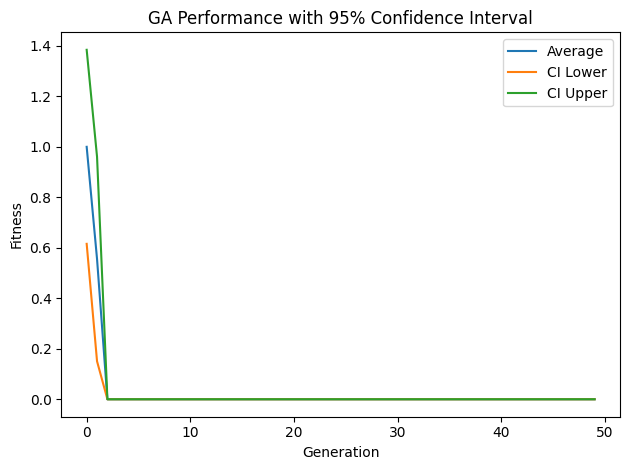

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_ci(csv_path: str):
    """
    Reads a GA-results CSV with 'generation' as the first column and plots:
      - avg
      - ci_lower
      - ci_upper
    across generations. Tries csv_path or ../Results/csv_path.
    """
    # Resolve file location
    if not os.path.isfile(csv_path):
        alt = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "Results", csv_path))
        if os.path.isfile(alt):
            csv_path = alt
        else:
            raise FileNotFoundError(f"Could not find '{csv_path}' or '{alt}'")
    
    # Load the data, using the first column as the index (generation)
    df = pd.read_csv(csv_path, index_col=0)
    
    generations = df.index
    avg = df['avg']
    lower = df['ci_lower']
    upper = df['ci_upper']
    
    # Create the plot
    plt.figure()
    plt.plot(generations, avg, label='Average')
    plt.plot(generations, lower, label='CI Lower')
    plt.plot(generations, upper, label='CI Upper')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('GA Performance with 95% Confidence Interval')
    plt.legend()
    plt.tight_layout()
    plt.show()

# use it 
plot_avg_ci('binary_test.csv')

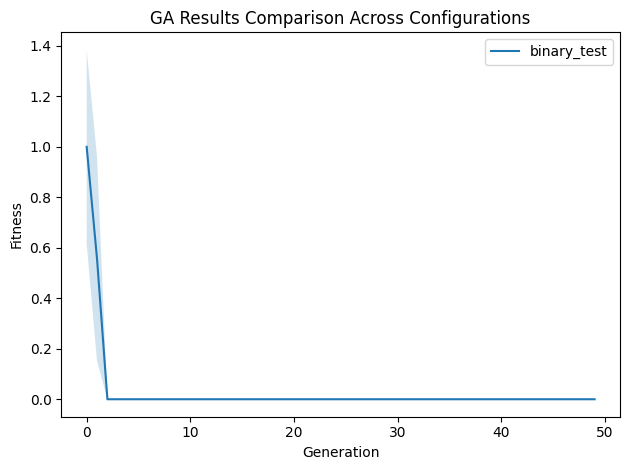

In [31]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

def plot_all_ga_results(results_dir: str):
    """
    Reads all CSV files in the given directory (or ../Results/) and overlays their
    avg and CI ribbons on a single plot. Assumes each CSV has 'generation'
    as its first column and columns: avg, ci_lower, ci_upper.
    """
    # Resolve directory
    if not os.path.isdir(results_dir):
        alt_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "Results"))
        if os.path.isdir(alt_dir):
            results_dir = alt_dir
        else:
            raise FileNotFoundError(f"Neither '{results_dir}' nor '{alt_dir}' exist as directories.")
    
    # Find CSVs
    csv_files = glob.glob(os.path.join(results_dir, "*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in directory '{results_dir}'.")
    
    plt.figure()
    for csv_path in csv_files:
        label = os.path.splitext(os.path.basename(csv_path))[0]
        df = pd.read_csv(csv_path, index_col=0)
        gens = df.index
        avg = df['avg']
        lower = df['ci_lower']
        upper = df['ci_upper']
        
        # Plot average and CI ribbon
        plt.plot(gens, avg, label=label)
        plt.fill_between(gens, lower, upper, alpha=0.2, label='_nolegend_')
    
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('GA Results Comparison Across Configurations')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_ga_results('Results')

In [24]:
# minimize fitness based on probability
def minimize(xo_prob, mut_prob):
    return random.random() < xo_prob and random.random() < mut_prob